# Neutrophil Temporal Latent Space Analysis

Time-dependent transcriptional programs in neutrophils are identified across a time course (0h, 2h, 4h, 6h, 8h, 24h). DRVI with 48 latent dimensions is used to capture fine-grained temporal variation, followed by statistical testing to identify latents significantly associated with time, and pathway enrichment to interpret the biological meaning of these programs.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install decoupler gseapy scikit-misc drvi-py 'scanpy[leiden]'

In [ ]:
!pip uninstall torchvision

In [ ]:
!pip install --upgrade scanpy

In [ ]:
import re
import drvi
import scvi
import numpy
import scipy
import torch
import gseapy
import scanpy
import pandas
import warnings
import decoupler
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.mixture import GaussianMixture
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, leaves_list


/usr/local/lib/python3.12/dist-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/lib/python3.12/dist-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


## Data Loading and Preparation

The blood cell atlas from the previous analysis is loaded and neutrophils (Leiden cluster 1) are extracted. 5000 highly variable genes are selected to focus the analysis on the most informative transcriptional variation.


In [ ]:
# Set random seeds for reproducibility
numpy.random.seed(0)
scvi.settings.seed = 0
warnings.filterwarnings('ignore')
torch.set_float32_matmul_precision('high')

INFO: Global seed set to 0
INFO:lightning.fabric.utilities.seed:Global seed set to 0


In [ ]:
# Load preprocessed blood cell atlas
adata = scanpy.read_h5ad('/content/drive/My Drive/neutrophills_singlecell/preprocessed_atlas_anndata.h5ad')

metadata = pandas.read_csv('/content/drive/My Drive/neutrophils_singlecell/atlas_metadata.tsv', sep='\t', index_col=0)

In [4]:
adata.obs = adata.obs.merge(metadata, left_index=True, right_index=True, how='left')

for c in ['leiden', 'cell_type']:
    if c in adata.obs:
        adata.obs[c] = adata.obs[c].astype('category')

In [ ]:
# Extract neutrophils (cluster 1)
adata = adata[adata.obs['leiden'].astype(str) == '1', :].copy() # type: ignore

In [ ]:
# Remove ENSG gene names (keep only gene symbols)
keep = ~adata.var_names.str.contains('ENSG', case=False, regex=True)
adata = adata[:, keep].copy() # type: ignore

In [ ]:
# Select highly variable genes (5000) accounting for donor batch effects
batch = 'donor'

adata.raw = adata.copy() # type: ignore
adata.layers['counts'] = adata.X.copy() # type: ignore

scanpy.pp.highly_variable_genes(
    adata, flavor='seurat_v3', span=1, subset=False,
    batch_key=batch, layer='counts', n_top_genes=5000
)

## DRVI Model Training

A DRVI model with 48 latent dimensions is trained to capture fine-grained temporal variation within neutrophils. The model regresses out donor effects while preserving time-dependent signals, enabling identification of temporal transcriptional programs.


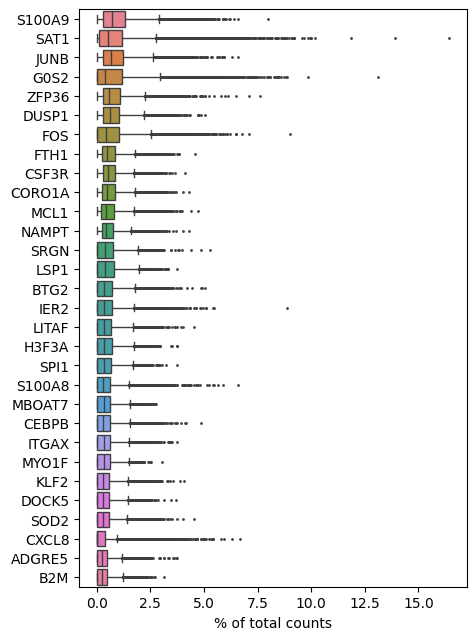

In [8]:
scanpy.pl.highest_expr_genes(adata, layer='counts')

## Training Assessment

Training convergence is monitored and latent dimension statistics are examined to ensure the model has learned meaningful representations.


In [ ]:
# Subset to highly variable genes only
adata = adata[:, adata.var['highly_variable']].copy() # type: ignore

In [ ]:
# Setup and train DRVI model (48 latents, regressing out donor)
drvi.model.DRVI.setup_anndata(adata, layer='counts', categorical_covariate_keys=[batch], is_count_data=True)

model = drvi.model.DRVI(adata, n_latent=48, categorical_covariates=[batch])

model.train(max_epochs=400, early_stopping=True)

ERROR:jax._src.xla_bridge:Jax plugin configuration error: Plugin module %s could not be loaded
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jax/_src/xla_bridge.py", line 432, in discover_pjrt_plugins
    plugin_module = importlib.import_module(plugin_module_name)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/importlib/__init__.py", line 90, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1387, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 935, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 999, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_re

INFO     DRVI: The model has been initialized                                                                      


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [21:29<00:00,  3.25s/it, v_num=1, train_loss_step=361, train_loss_epoch=388]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [21:29<00:00,  3.22s/it, v_num=1, train_loss_step=361, train_loss_epoch=388]


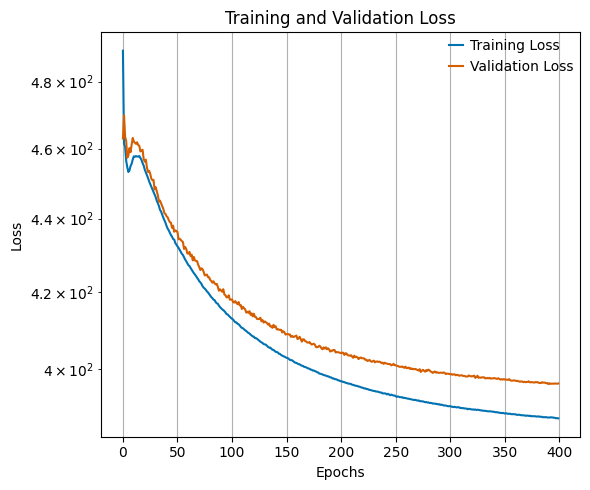

In [ ]:
# Plot training and validation loss curves
elbo = model.history['elbo_train'] # type: ignore
elbo['elbo_validation'] = model.history['elbo_validation'] # type:ignore

val_color = '#D55E00'  # Orange
train_color = '#0072B2'  # Blue

plt.figure(figsize=(6, 5))

plt.plot(elbo.index,  elbo['elbo_train'], color=train_color, linestyle='-', label='Training Loss')
plt.plot(elbo.index, elbo['elbo_validation'], color=val_color, linestyle='-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()

In [ ]:
# Extract latent representation from trained model
adata.obsm['X_drvi'] = model.get_latent_representation() # type: ignore

In [ ]:
# Compute neighbors and UMAP on latent space
scanpy.pp.neighbors(adata, use_rep='X_drvi', metric='correlation')
scanpy.tl.umap(adata, min_dist=0.3)

### Batch Effect Assessment

The UMAP is visualized colored by donor, time point, and Leiden clusters to confirm that the clustering structure reflects biological variation rather than technical batch effects. Good batch correction should show mixing of donors within clusters while preserving the biological signal of time-dependent variation.


In [ ]:
# Randomize cell order for better visualization
scanpy.pp.subsample(adata, fraction=1.0)

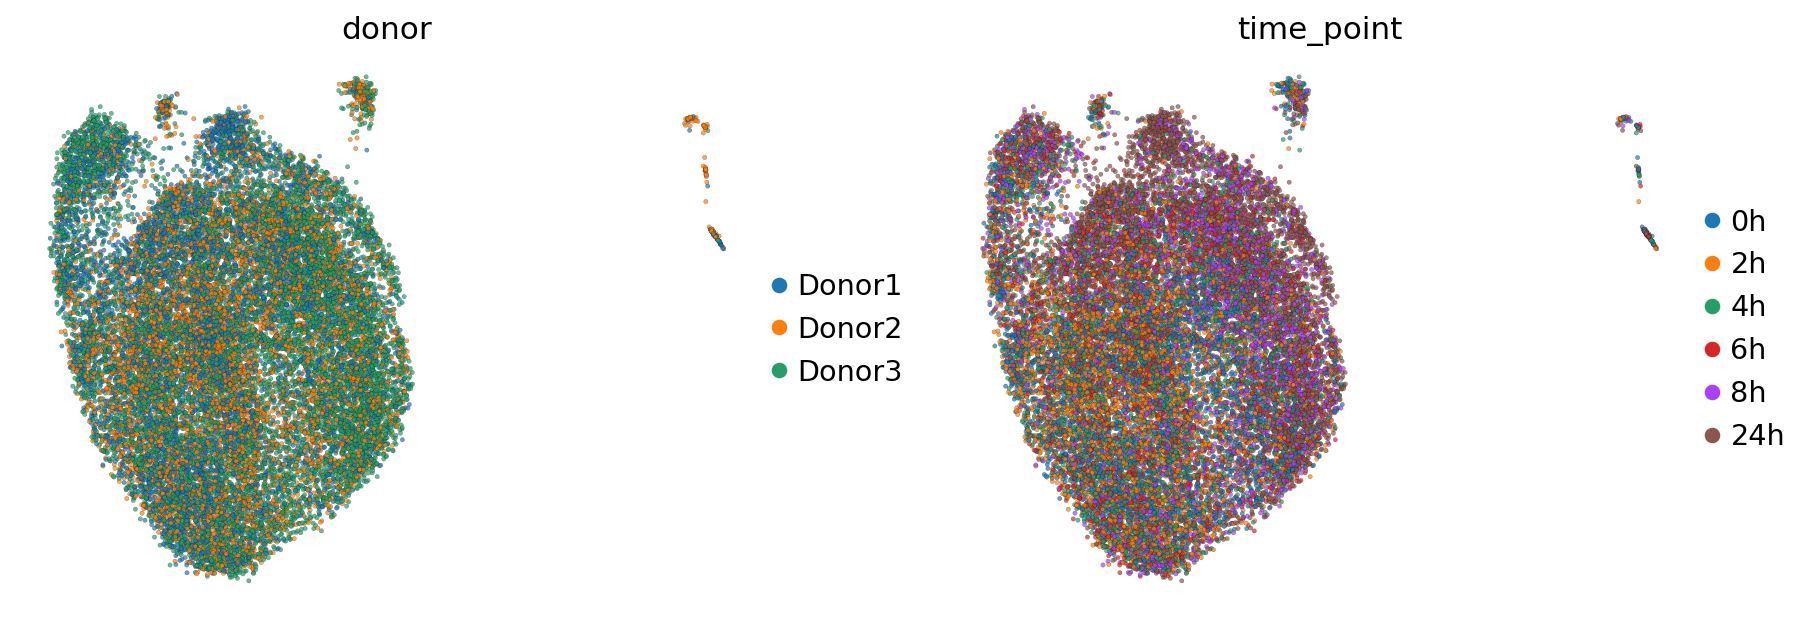

In [15]:
scanpy.settings.set_figure_params(figsize=(6, 4.5)) # type: ignore
scanpy.pl.umap(adata, color=['donor', 'time_point'], size=15, alpha=0.7, edgecolor='black', linewidth=0.1, frameon=False)

In [ ]:
# Create AnnData object for latent dimensions and compute their statistics
Z = adata.obsm['X_drvi']

n_latent = Z.shape[1]


embed = scanpy.AnnData(
    X=Z,
    obs=adata.obs.copy(),
    var=pandas.DataFrame(index=[f"z{j}" for j in range(n_latent)]),
)

embed.var['original_dim_id'] = numpy.arange(n_latent)

drvi.utils.tl.set_latent_dimension_stats(model, embed)

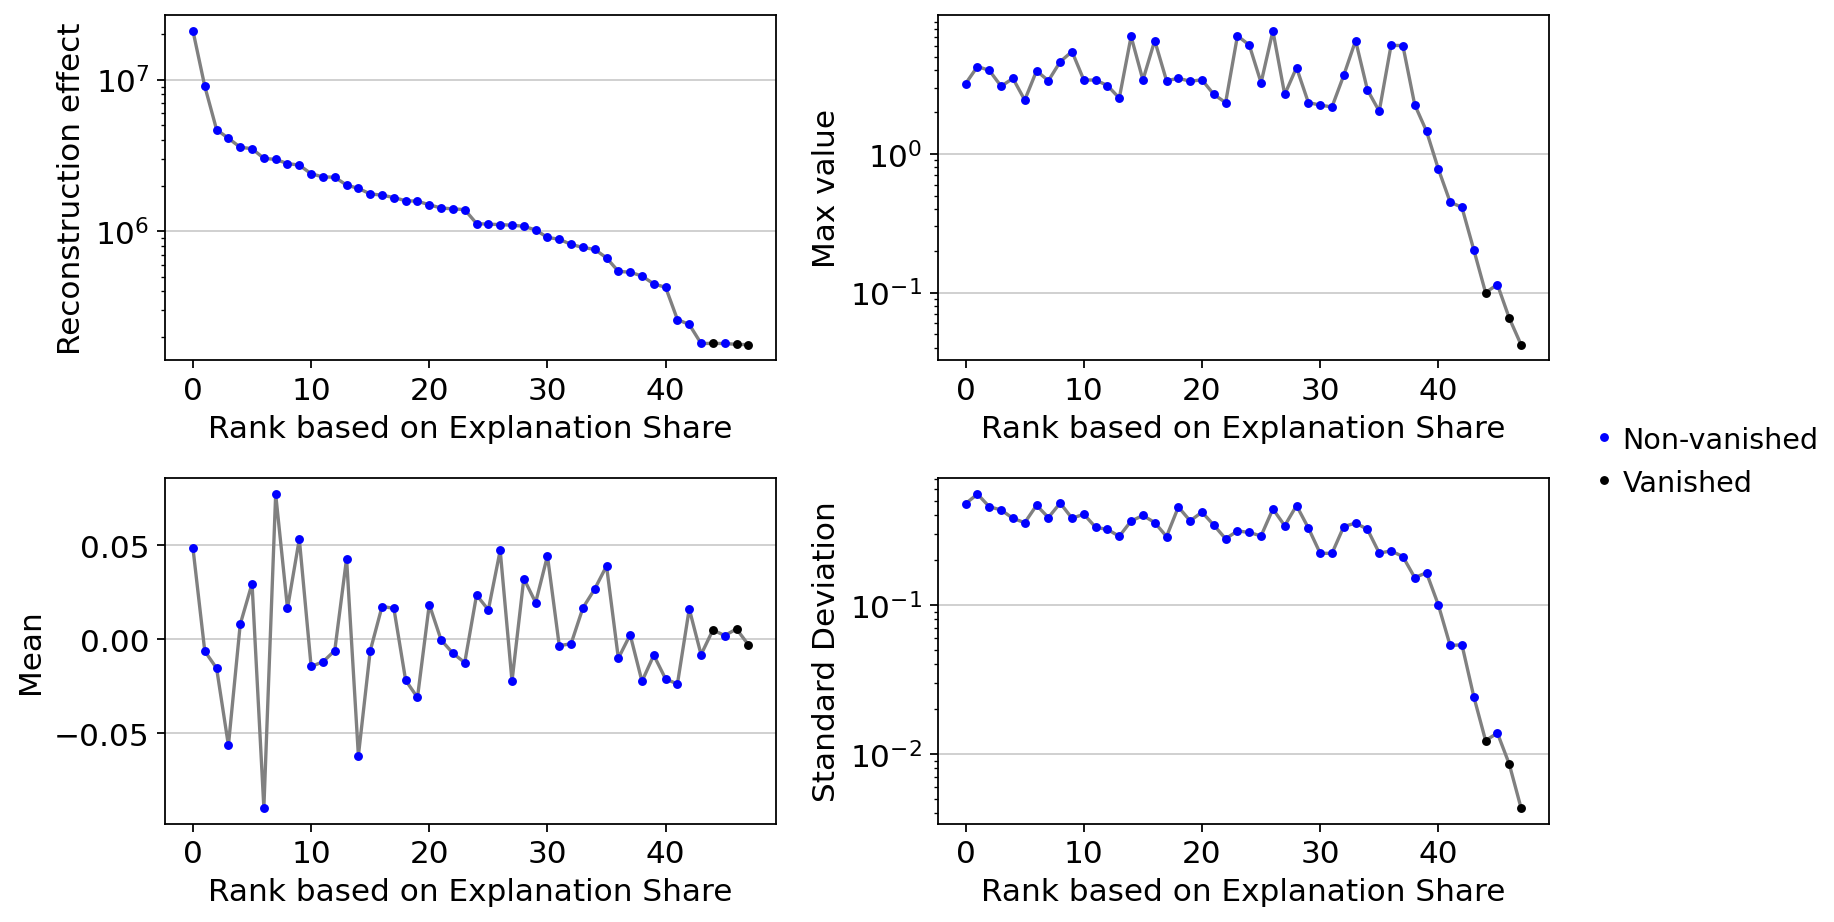

In [17]:
drvi.utils.pl.plot_latent_dimension_stats(embed, ncols=2)

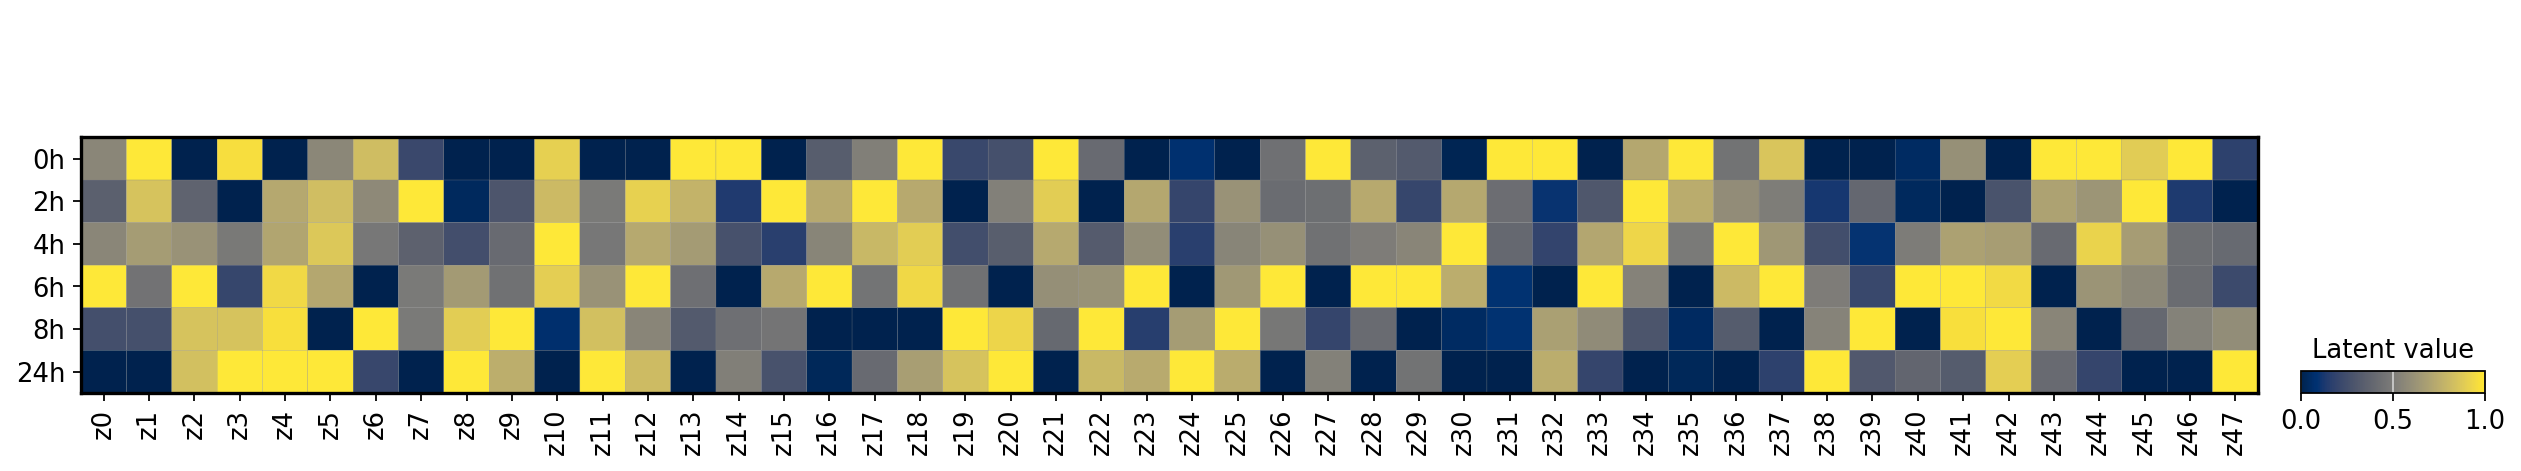

In [18]:
scanpy.pl.matrixplot(
    embed,
    var_names=embed.var_names,   # type: ignore
    groupby='time_point',        # grouping variable
    standard_scale='var',        # scale each latent
    colorbar_title='Latent value',
    cmap='cividis'
)

## Stress Response Validation

The MP5 gene signature (FOS, FOSB, JUN, JUNB, IER2, IER3, EGR1, ATF3, HSPA1A, HSPA1B, DNAJB1) represents an immediate stress response program identified in the original neutrophil study. Cells are scored for this signature to validate that the model captures known biological patterns.


In [ ]:
# Normalize and score cells for MP5 stress signature
adata.layers['logcounts'] = adata.layers['counts'].copy() # type: ignore

scanpy.pp.normalize_total(adata, target_sum=1e4, layer='logcounts')
scanpy.pp.log1p(adata, layer='logcounts')

# mp5 stress program referenced in the original study
mp5 = ['FOS','FOSB','JUN','JUNB','IER2','IER3','EGR1','ATF3','HSPA1A','HSPA1B','DNAJB1']

genes = [g for g in mp5 if g in adata.var_names]

scanpy.tl.score_genes(adata, gene_list=genes, score_name='mp5_score', layer='logcounts')

<Axes: title={'center': 'mp5_score'}, xlabel='UMAP1', ylabel='UMAP2'>

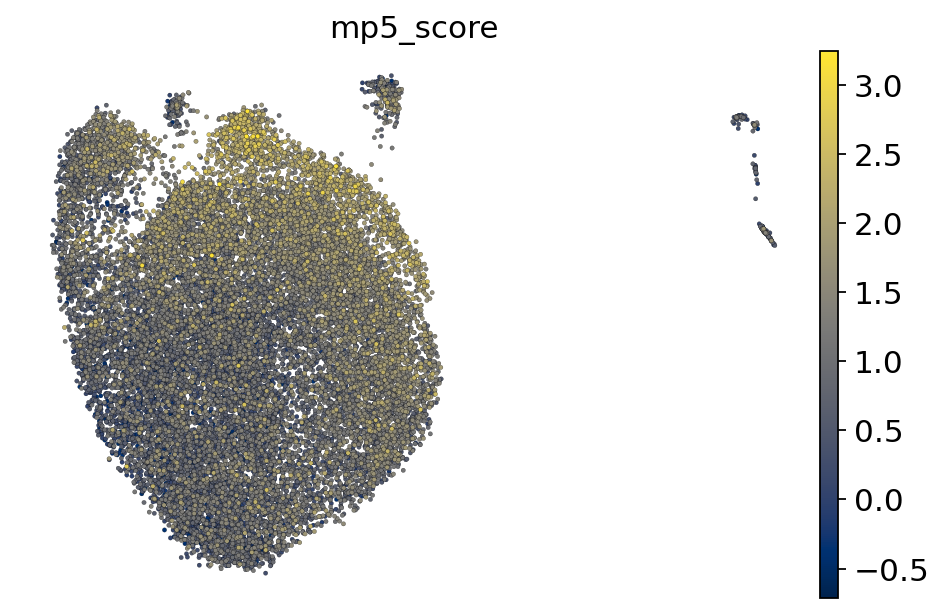

In [20]:
scanpy.settings.set_figure_params(figsize=(7, 4.5)) # type: ignore

# UMAP: mp5_score
scanpy.pl.umap(
    adata, color='mp5_score',
    size=15, edgecolor='black', linewidth=0.1,
    frameon=False, cmap='cividis', show=False
)


In [ ]:
# Traverse latents to identify differentially expressed genes per latent dimension
traverse_adata = drvi.utils.tl.traverse_latent(model, embed, n_samples=20, max_noise_std=0.0)
drvi.utils.tl.calculate_differential_vars(traverse_adata)

degs = drvi.utils.tools.iterate_on_top_differential_vars(traverse_adata, 'combined_score') # type: ignore

def drvi_top_table(deg_tuples, top_n=5):
    rows = []
    for label, series in deg_tuples:
        # label looks like 'DR 1-' or 'DR 1+'
        m = re.match(r'^(.*?)([+-])$', str(label).strip())
        if m:
            latent, direction = m.group(1).strip(), m.group(2)
        else:
            latent, direction = str(label).strip(), ''

        # ensure Series and sort descending
        s = pandas.Series(series).sort_values(ascending=False).head(top_n)

        for gene, score in s.items():
            rows.append({
                'gene': str(gene),
                'latent': latent,       # e.g., 'DR 1'
                'direction': direction, # '+' or '-'
                'score': float(score)
            })

    return pandas.DataFrame(rows, columns=['gene', 'latent', 'direction', 'score'])

traversing latent ...
Input latent shape: control: (19200, 48), effect: (19200, 48)
Output mean param shape: control: (19200, 5000), effect: (19200, 5000)
Finding differential variables per latent dimension ...


In [22]:
top_genes = drvi_top_table(degs, top_n=20)

In [ ]:
# Create pseudobulk data (average latents per donor × timepoint)
pdata = decoupler.pp.pseudobulk(adata=embed, sample_col='donor', groups_col='time_point', mode='mean', skip_checks=True)

In [24]:
pdata

AnnData object with n_obs × n_vars = 18 × 48
    obs: 'donor', 'time_point', 'tissue', 'capture_batch', 'predicted_doublet', 'leiden', 'cell_type', '_scvi_labels', 'psbulk_cells', 'psbulk_counts'
    var: 'original_dim_id', 'reconstruction_effect', 'order', 'max_value', 'mean', 'min', 'max', 'std', 'title', 'vanished'
    layers: 'psbulk_props'

## Statistical Testing for Time-Associated Latents

Linear regression is used to test which latent dimensions change significantly with time. Each latent is modeled as a function of time (continuous) while controlling for donor effects. P-values are corrected for multiple testing using the Benjamini-Hochberg FDR method.


In [25]:
# 0) Tidy dataframe
df = pdata.to_df().join(pdata.obs.copy())


# 1) Ensure numeric time
if 'time_point_int' not in df.columns:
    df['time_point_int'] = (
        df['time_point'].astype(str).str.strip().str.replace('h', '', regex=False).astype(int)
    )


# 2) Choose latents
latents = list(pdata.var_names)
if 'vanished' in pdata.var.columns:
    latents = [lv for lv in latents if not bool(pdata.var.loc[lv, 'vanished'])]


# 2a) Z-score each latent (store as new columns with '_z')
Z = df[latents].astype(float)
mean = Z.mean(0)
std = Z.std(0, ddof=0).replace(0.0, 1.0)
Zz = (Z - mean) / std

for c in latents:
    df[c + '_z'] = Zz[c]

results = []


# 3) OLS per latent (use z-scored values): latent_z ~ time_point_int + C(donor)
for latent in latents:
    dsub = df[['time_point_int', 'donor', latent + '_z']].dropna()
    if dsub.empty:
        continue
    fit = ols(f'{latent}_z ~ time_point_int + C(donor)', data=dsub).fit()

    slope = fit.params.get('time_point_int', numpy.nan)
    pval = fit.pvalues.get('time_point_int', numpy.nan)
    stderr = fit.bse.get('time_point_int', numpy.nan)
    intercept = fit.params.get('Intercept', numpy.nan)

    results.append({
        'latent': latent,  # report original name
        'slope_time': slope,
        'pval_time': pval,
        'se_time': stderr,
        'intercept': intercept
    })


# 4) Multiple testing correction
res_df = pandas.DataFrame(results).sort_values('pval_time').reset_index(drop=True)

if not res_df.empty:
    res_df['fdr_bh'] = multipletests(res_df['pval_time'].values, method='fdr_bh')[1]
    res_df['neglog10_p'] = -numpy.log10(res_df['pval_time'].clip(lower=1e-300))
    res_df['direction'] = numpy.where(res_df['slope_time'] > 0, 'up_with_time', 'down_with_time')


# 5) Optional: join latent metadata
meta_cols = [c for c in ['title', 'original_dim_id', 'reconstruction_effect'] if c in pdata.var.columns]

if meta_cols and not res_df.empty:
    meta_df = pdata.var[meta_cols].copy()
    meta_df['latent'] = meta_df.index
    res_df = res_df.merge(meta_df, on='latent', how='left')


In [26]:
res_df[res_df['fdr_bh'] < 0.05]

,latent,slope_time,pval_time,se_time,intercept,fdr_bh,neglog10_p,direction,title,original_dim_id,reconstruction_effect
0,z38,0.118856,7.700431e-08,0.011702,-0.860750,0.000003,7.113485,up_with_time,DR 27,38,1.105181e+06
1,z21,-0.111232,1.905969e-06,0.014307,0.502159,0.000041,5.719884,down_with_time,DR 19,21,1.587729e+06
2,z13,-0.112184,2.731087e-06,0.014889,0.631847,0.000041,5.563665,down_with_time,DR 5,13,3.577295e+06
3,z1,-0.105954,5.387031e-05,0.018555,0.832242,0.000606,4.268651,down_with_time,DR 46,1,1.814485e+05
4,z45,-0.093244,9.758170e-05,0.017341,0.990482,0.000878,4.010632,down_with_time,DR 31,45,9.094678e+05
5,z24,0.097187,3.429877e-04,0.020690,-0.967269,0.002397,3.464721,up_with_time,DR 3,24,4.674830e+06
6,z11,0.098435,3.728466e-04,0.021154,-0.734407,0.002397,3.428470,up_with_time,DR 34,11,7.803192e+05
7,z31,-0.082637,4.318162e-03,0.024309,0.639037,0.024290,2.364701,down_with_time,DR 42,31,2.608637e+05
8,z37,-0.035453,6.542053e-03,0.011112,1.515300,0.032710,2.184286,down_with_time,DR 22,37,1.421434e+06
9,z20,0.055163,9.257924e-03,0.018292,-1.296213,0.041661,2.033486,up_with_time,DR 28,20,1.094668e+06


### Results

The table above shows latent dimensions significantly associated with time (FDR < 0.05). Each significant latent represents a distinct transcriptional program that systematically changes across the time course. The slope indicates whether the program increases or decreases with time.


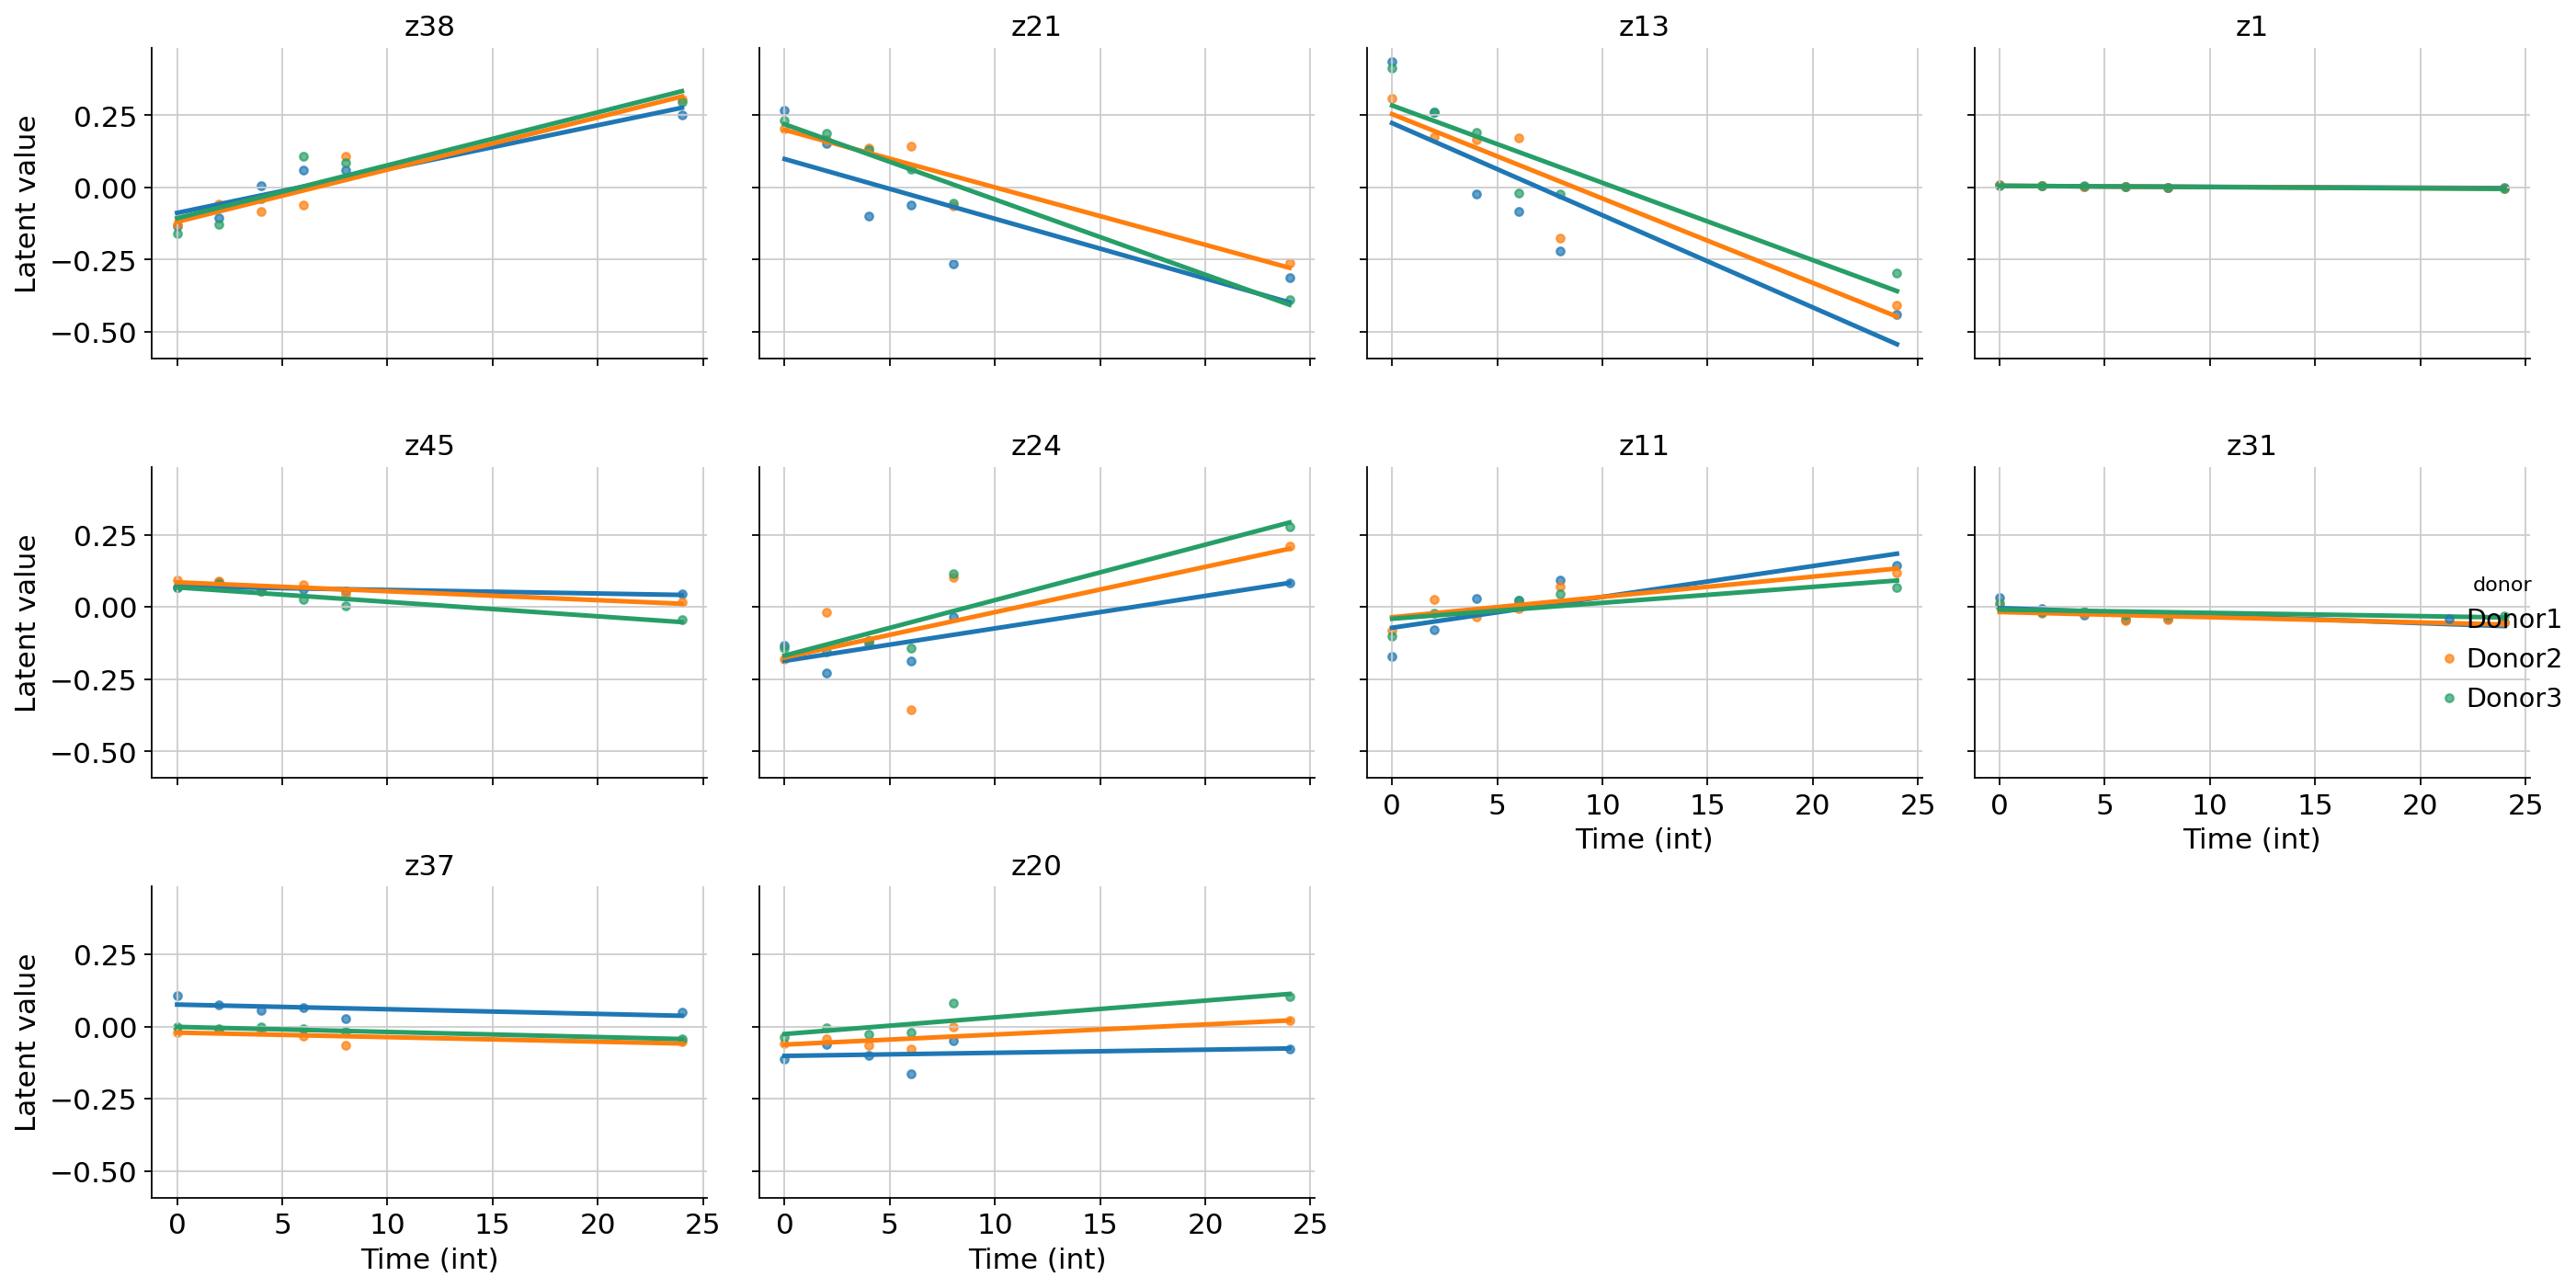

In [ ]:
# Plot trends of significant latents over time
latent_cols = res_df[res_df['fdr_bh'] < 0.05]['latent'].tolist()

df_long = df.melt(
    id_vars=['time_point_int', 'donor'],
    value_vars=latent_cols,
    var_name='latent',
    value_name='value'
)

g = sns.lmplot(
    data=df_long, x='time_point_int', y='value',
    hue='donor', col='latent', col_wrap=4,
    markers='o', ci=0,
    height=3, aspect=1.4,
    scatter_kws={'s': 15, 'alpha': 0.7}
)

g.set_axis_labels('Time (int)', 'Latent value')
g.set_titles(col_template='{col_name}')
plt.tight_layout()

plt.show()

In [ ]:
# Extract significant latents for gene set analysis
top_latents = res_df[res_df['fdr_bh'] < 0.05]
latent_list = top_latents['title'].tolist()

In [29]:
k = 20

# latents to use
latent_list = top_latents['title'].tolist()

# map latent → trend sign based on 'direction' column
trend_sign = (
    top_latents
    .assign(_sign=top_latents['direction'].map({'up_with_time': '+', 'down_with_time': '-'}))
    .set_index('title')['_sign']
    .to_dict()
)

# take top-k per latent × (DR ±)
tg = (top_genes[top_genes['latent'].isin(latent_list)]
        .sort_values('score', ascending=False)
        .groupby(['latent','direction'], group_keys=False)
        .head(k))

# map latent± → time±
def to_time_dir(row):
    s = trend_sign.get(row['latent'])
    if s == '+':   # latent goes up with time
        return '+' if row['direction'] == '+' else '-'
    if s == '-':   # latent goes down with time
        return '-' if row['direction'] == '+' else '+'
    return None

tg['time_dir'] = tg.apply(to_time_dir, axis=1) # type: ignore
tg = tg.dropna(subset=['time_dir'])

# unions
pos_with_time = sorted(set(tg.loc[tg['time_dir'] == '+', 'gene']))
neg_with_time = sorted(set(tg.loc[tg['time_dir'] == '-', 'gene']))

# optional quick checks
print('time+ genes:', len(pos_with_time))
print('time- genes:', len(neg_with_time))


time+ genes: 95
time- genes: 140


In [ ]:
# Load MSigDB Hallmark gene sets
msig = gseapy.Msigdb()
gmt = msig.get_gmt(category='h.all', dbver='2025.1.Hs')

## Gene Set Enrichment Analysis

For each significant time-associated latent, top genes are extracted in each direction. Latent directions are then mapped to time directions based on whether the latent increases or decreases with time. This yields two gene sets: genes increasing with time and genes decreasing with time, which are tested for pathway enrichment.


Genes upregulated with time show signatures of stress and apoptosis, consistent with results from the original paper.

In [ ]:
# Pathway enrichment for genes increasing with time
enr = gseapy.enrichr(gene_list=pos_with_time, gene_sets=gmt, organism='human', outdir=None, background=adata.raw.var_names) # type: ignore
enr.results[enr.results['Adjusted P-value'] < 0.01].sort_values('Adjusted P-value').head() # type: ignore

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
32,gs_ind_0,HALLMARK_TNFA_SIGNALING_VIA_NFKB,17/199,2.951995e-21,1.062718e-19,44.227467,2090.712228,RELB;NR4A3;DUSP2;IER5;EGR2;GADD45B;JUN;F2RL1;N...
30,gs_ind_0,HALLMARK_P53_PATHWAY,7/192,7.488912e-07,1.348004e-05,16.539586,233.285439,IER5;JUN;TOB1;TAX1BP3;CDK5R1;ISCU;IER3
18,gs_ind_0,HALLMARK_HYPOXIA,5/200,1.829163e-04,1.646247e-03,11.251176,96.833046,JUN;CHST2;PNRC1;IER3;TNFAIP3
10,gs_ind_0,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,5/200,1.829163e-04,1.646247e-03,11.251176,96.833046,GADD45B;JUN;SLC6A8;VIM;TNFAIP3
3,gs_ind_0,HALLMARK_APOPTOSIS,4/159,8.125975e-04,5.850702e-03,11.459649,81.538549,IER3;GADD45B;JUN;PMAIP1


ORA of genes that go down with time doesn't prove to be useful. Some pathways overlap with the ORA of the up genes but overlap is minimal.

In [ ]:
# Pathway enrichment for genes decreasing with time
enr = gseapy.enrichr(gene_list=neg_with_time, gene_sets=gmt, organism='human', outdir=None, background=adata.raw.var_names) # type: ignore
enr.results[enr.results['Adjusted P-value'] < 0.05].sort_values('Adjusted P-value').head() # type: ignore

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
11,gs_ind_0,HALLMARK_E2F_TARGETS,7/198,0.000012,0.000475,10.605949,120.014137,CDK1;CIT;MKI67;CENPM;SPC25;MELK;RRM2
9,gs_ind_0,HALLMARK_COMPLEMENT,5/200,0.001079,0.010525,7.505280,51.270699,S100A12;KYNU;GP9;CR1;CLU
36,gs_ind_0,HALLMARK_TNFA_SIGNALING_VIA_NFKB,5/199,0.001056,0.010525,7.544076,51.703747,KYNU;EDN1;BCL2A1;PER1;PFKFB3
22,gs_ind_0,HALLMARK_INFLAMMATORY_RESPONSE,5/200,0.001079,0.010525,7.505280,51.270699,ADM;SCARF1;EDN1;OSM;ITGB3
8,gs_ind_0,HALLMARK_COAGULATION,4/138,0.002019,0.015747,8.875240,55.072751,GP9;SPARC;ITGB3;CLU


### Biological Interpretation

Genes increasing with time show enrichment for inflammatory and activation pathways, consistent with neutrophil responses to ex vivo culture stress. Genes decreasing with time represent homeostatic programs that are progressively lost during ex vivo culture.


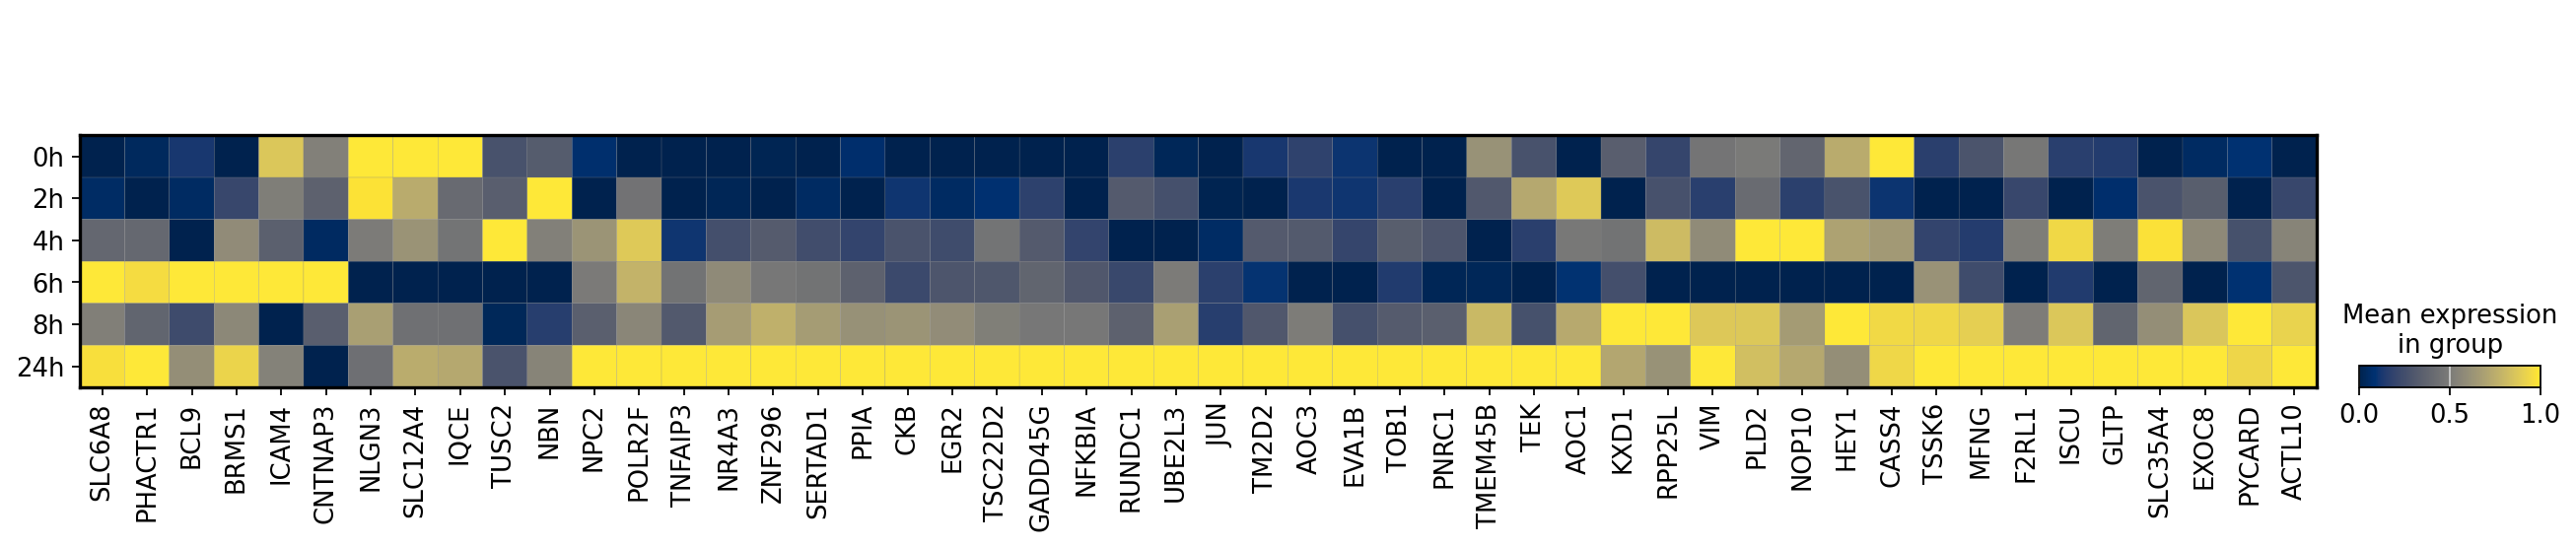

In [ ]:
# Heatmap of genes increasing with time (hierarchically clustered)
# randomly sample down the vector of genes for visualization
pos_with_time = numpy.random.choice(pos_with_time, size=50, replace=False)

# 1) compute group means (genes × time)
means = (
    pandas.DataFrame(
        adata[:, pos_with_time].layers['logcounts'].A, # type: ignore
        index=adata.obs.index, columns=pos_with_time
    )
    .assign(time_point=adata.obs['time_point'].values)
    .groupby('time_point').mean()
    .T
)

# 2) cluster genes on their time profiles
Z = linkage(means.values, method='complete', metric='correlation')
order = leaves_list(Z)
genes_ordered = means.index[order].tolist()

scanpy.settings.set_figure_params(figsize=(8, 5)) # type: ignore

# 3) plot with the clustered gene order
scanpy.pl.matrixplot(
    adata,
    var_names=genes_ordered,
    groupby='time_point',
    use_raw=False,
    standard_scale='var',
    dendrogram=False,   # we’ve already ordered genes
    swap_axes=False,
    cmap='cividis'
)

## Temporal Gene Expression Patterns

The clustered heatmaps below show how top time-associated genes change across the time course. Genes are ordered by hierarchical clustering to group those with similar temporal dynamics together.


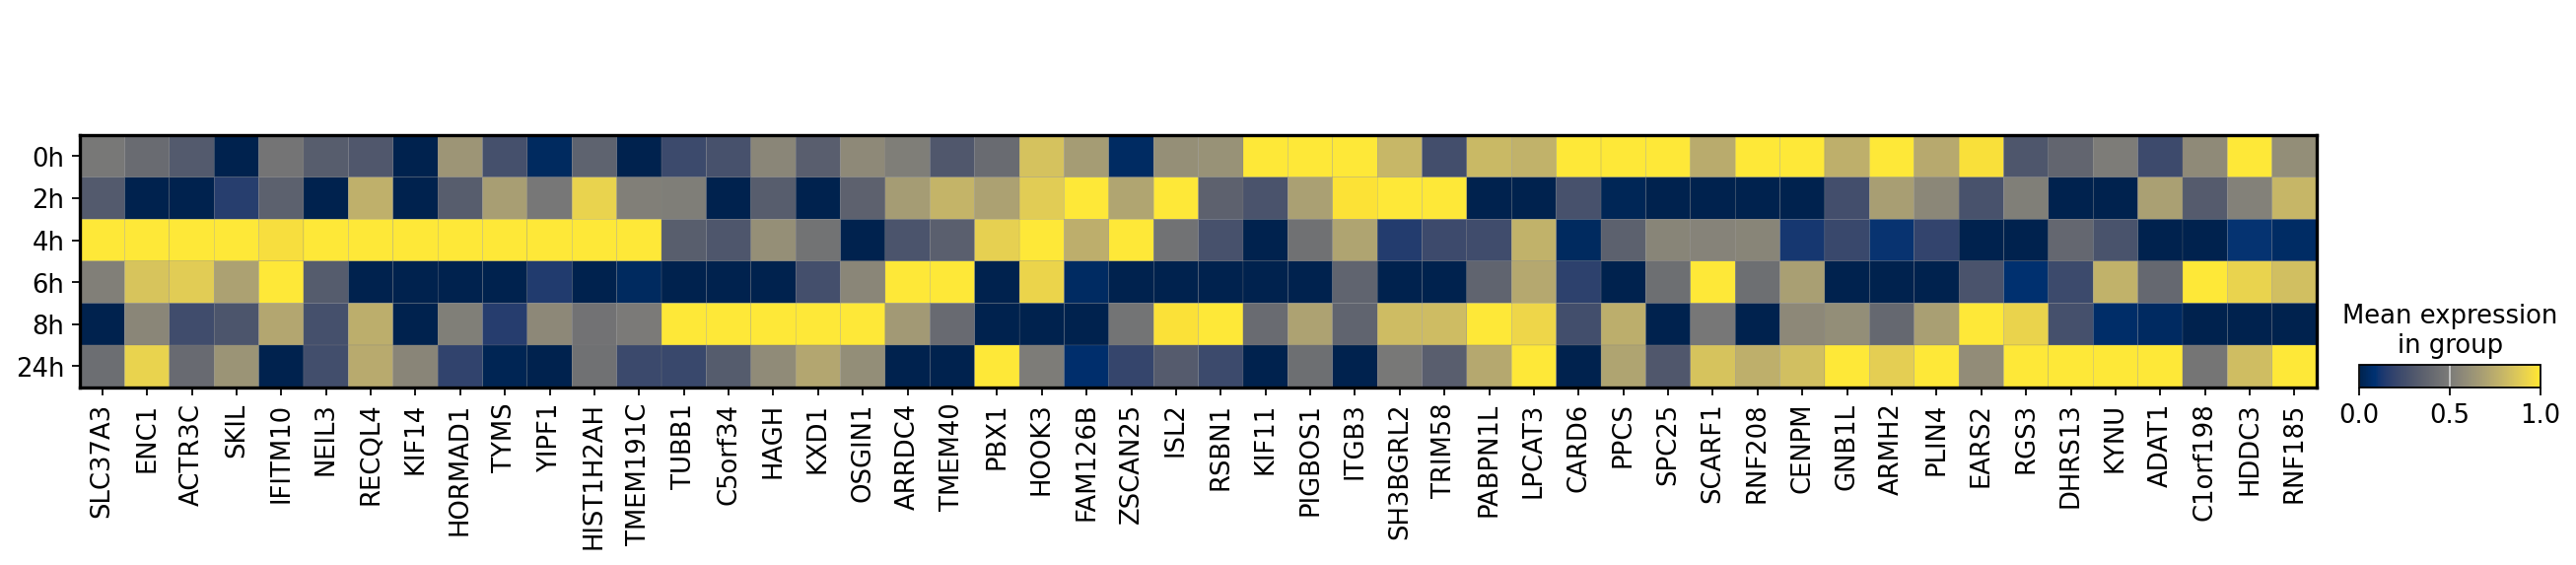

In [ ]:
# Heatmap of genes decreasing with time (hierarchically clustered)
# randomly sample down the vector of genes for visualization
neg_with_time = numpy.random.choice(neg_with_time, size=50, replace=False)

# 1) compute group means (genes × time)
means = (
    pandas.DataFrame(
        adata[:, neg_with_time].layers['logcounts'].A, # type: ignore
        index=adata.obs.index, columns=neg_with_time
    )
    .assign(time_point=adata.obs['time_point'].values)
    .groupby('time_point').mean()
    .T
)

# 2) cluster genes on their time profiles
Z = linkage(means.values, method='complete', metric='correlation')
order = leaves_list(Z)
genes_ordered = means.index[order].tolist()

scanpy.settings.set_figure_params(figsize=(8, 5)) # type: ignore

# 3) plot with the clustered gene order
scanpy.pl.matrixplot(
    adata,
    var_names=genes_ordered,
    groupby='time_point',
    use_raw=False,
    standard_scale='var',
    dendrogram=False,   # we’ve already ordered genes
    swap_axes=False,
    cmap='cividis'
)